# <span style="color:blue">Cyberattack Patterns in the NSL-KDD data set

The NSL-KDD dataset is a cleaned version of data from the 1999 KDD Cup competition. The competition purpose was to predict internet attacks in internet traffic records obtained from a controlled experiment on a simulated military network. The project was managed by MIT Lincoln Labs, who operated the local area network (LAN) as if it were a true Air Force environment, but then attacked it repeatedly. The original data had numerous flaws, including duplicate records. This project uses the updated and cleaner NSL-KDD dataset, created and released by the Canadian Institute for Cybersecurity at the University of New Brunswick.  

My objective is to use two unsupervised learning techniques, One-Class SVM (Support Vector Machine) and an ensemble technique called isolation forest to identify pattens and anomalies in the dataset and how they correlate with normal and nefarious internet traffic.

I begin by loading staple packages, importing the data, and exploratory data analysis.

In [148]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimpy import skim
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import itertools

### <span style="color:blue">Import data and set variable types

In [142]:
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                "num_failed_logins", "logged_in", "num_compromised", "root_shell",
                "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login",
                "is_guest_login", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
                "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
                "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                "dst_host_srv_serror_rate", "dst_host_rerror_rate",
                "dst_host_srv_rerror_rate", "attack_type", "success_pred"]

train = pd.read_csv("KDDTrain+_20Percent.txt", sep = ",", header = None, names = column_names)
test = pd.read_csv("KDDTest+.txt", sep = ",", header = None, names = column_names)

# Create vectors of names for each variable type 
categorical_indices = [x-1 for x in [2,3,4,42]]
categorical_features = [column_names[i] for i in categorical_indices]

binary_indices = [x-1 for x in [7, 12, 14, 20, 21, 22]]
binary_features = [column_names[i] for i in binary_indices]

continuous_indices = [x-1 for x in [1, 5, 6, 10, 11, 13, 16, 17, 18, 19]]
continuous_features = [column_names[i] for i in continuous_indices]

discrete_indices = [x-1 for x in ([8,9,15] + list(range(23,42)) + [43])]
discrete_features = [column_names[i] for i in discrete_indices]

# Set variable types
train[categorical_features] = train[categorical_features].astype('category')
train[binary_features] = train[binary_features].astype('category')

test[categorical_features] = test[categorical_features].astype('category')
test[binary_features] = test[binary_features].astype('category')

# <span style="color:blue">Exploratory Data Analysis

### <span style="color:blue">Inspect the data

In [143]:
print("First 6 columns of train.head()\n", train.iloc[:, 0:6].head())
skim(train)

# design_report = ProfileReport(train, minimal=True)
# design_report.to_file(output_file='NSLKDD_20Percent_profile_report.html')

First 6 columns of train.head()
    duration protocol_type   service flag  src_bytes  dst_bytes
0         0           tcp  ftp_data   SF        491          0
1         0           udp     other   SF        146          0
2         0           tcp   private   S0          0          0
3         0           tcp      http   SF        232       8153
4         0           tcp      http   SF        199        420


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 25192  │ │ int64       │ 18    │ │ protocol_type         │                                │
│ │ Number of columns │ 43     │ │ float64     │ 15    │ │ service               │                                │
│ └───────────────────┴────────┘ │ category    │ 10    │ │ flag                  │                                │
│                                └─────────────┴───────┘ │ land                  │                                │
│                                                        │ logged_in             │                                │
│                                                        │ root_shell            │                                │
│                                                        │ num_outbound_cmds     │                                │
│                                                        │ is_host_login         │                                │
│                                                        │ is_guest_login        │                                │
│                                                        │ attack_type           │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean      ┃ sd        ┃ p0  ┃ p25   ┃ p75   ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ duration                 │   0 │     0 │       310 │      2700 │   0 │     0 │     0 │      43000 │   █    │  │
│ │ src_bytes                │   0 │     0 │     24000 │   2400000 │   0 │     0 │   280 │  380000000 │   █    │  │
│ │ dst_bytes                │   0 │     0 │      3500 │     89000 │   0 │     0 │   530 │    5200000 │   █    │  │
│ │ wrong_fragment           │   0 │     0 │     0.024 │      0.26 │   0 │     0 │     0 │          3 │   █    │  │
│ │ urgent                   │   0 │     0 │     4e-05 │    0.0063 │   0 │     0 │     0 │          1 │   █    │  │
│ │ hot                      │   0 │     0 │       0.2 │       2.2 │   0 │     0 │     0 │         77 │   █    │  │
│ │ num_failed_logins        │   0 │     0 │    0.0012 │     0.045 │   0 │     0 │     0 │          4 │   █    │  │
│ │ num_compromised          │   0 │     0 │      0.23 │        10 │   0 │     0 │     0 │        880 │   █    │  │
│ │ su_attempted             │   0 │     0 │    0.0013 │     0.049 │   0 │     0 │     0 │          2 │   █    │  │
│ │ num_root                 │   0 │     0 │      0.25 │        12 │   0 │     0 │     0 │        980 │   █    │  │
│ │ num_file_creations       │   0 │     0 │     0.015 │      0.53 │   0 │     0 │     0 │         40 │   █    │  │
│ │ num_shells               │   0 │     0 │   0.00036 │     0.019 │   0 │     0 │     0 │          1 │   █    │  │
│ │ num_access_files         │   0 │     0 │    0.0043 │     0.099 │   0 │     0 │     0 │          8 │   █    │  │
│ │ count                    │   0 │     0 │        85 │       110 │   1 │     2 │   140 │        510 │  █▂▂▁  │  │
│ │ srv_count                │   0 │     0 │        28 │

#### <span style="color:blue">Remove variables with no variation or little variation
- no variation: 'num_outbound_cmds', 'urgent', 'is_host_login', 'is_guest_login'\
- little variation: 'land'

In [144]:
train = train.drop(['land','num_outbound_cmds', 'urgent', 'is_host_login', 'is_guest_login'], axis=1)
test = test.drop(['land','num_outbound_cmds', 'urgent', 'is_host_login', 'is_guest_login'], axis=1);

#### <span style="color:blue">Add attack class feature to data

In [169]:
attack_counts = train['attack_type'].value_counts()
attack_counts

# Add attack_class feature to data
DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
U2R = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
R2L = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']
normal = ['normal']
attack_class_dict = {'DoS': DoS,
                     'Probe': Probe,
                     'U2R': U2R,
                     'R2l': R2L,
                     'normal': normal}

rev_ac_dict = {value: key for key, values in attack_class_dict.items() for value in values}

train['attack_class'] = [rev_ac_dict[attack] for attack in train['attack_type']]
train['attack_class'] = train['attack_class'].astype('category')

#### <span style="color:blue">Overrall Attack Frequency

In [168]:
num_attacks=train[train['attack_type']!= 'normal'].shape[0]
num_records=train.shape[0]

print('\n"normal" network traffic:', num_records)
print("number of attacks:", num_attacks)
print("attack percentage: ", round(100*num_attacks/num_records), "%", sep = "")


"normal" network traffic: 25192
number of attacks: 11743
attack percentage: 47%


#### <span style="color:blue">Distribution of attack class

In [164]:
series = pd.Series(train['attack_class'])
ac_dist = series.value_counts().reset_index()
ac_dist.columns = ['attack class', 'count']

ac_dist

,attack class,count
0,normal,13449
1,DoS,9234
2,Probe,2289
3,R2l,209
4,U2R,11


#### <span style="color:blue">Ease of prediction by attack class (0 = hardest, 21 easiest)

In [166]:
attack_class_pred = {'DoS': [],
                     'Probe': [],
                     'U2R': [],
                     'R2l': [],
                     'normal': []}

for i,record in train.iterrows():
    score = record['success_pred']
    attack_class = record['attack_class']
    attack_class_pred[attack_class].append(score)

key_mean_pairs = []
for key, scores in attack_class_pred.items():
    key_mean_pairs.append((key, round(np.mean(scores))))

scores_df = pd.DataFrame(key_mean_pairs, columns =['attack class', 'prediction ease'])

scores_df.sort_values(by='prediction ease', ascending = False)

,attack class,prediction ease
4,normal,20
0,DoS,19
1,Probe,16
3,R2l,10
2,U2R,5


#### <span style="color:blue">Bargraph of Attack Frequency by Class

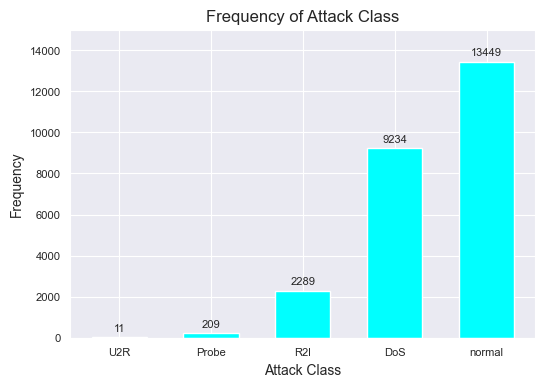

In [114]:
# print(train['attack_class'].value_counts())
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize = (6,4))

classes = train['attack_class'].unique().tolist()
counts = train['attack_class'].value_counts().tolist()

labels = [x for _,x in sorted(zip(counts, classes))]
counts.sort()

# Set fontsizes
plt.rc('axes', titlesize = 8)
plt.rc('axes', labelsize = 10)
plt.rc('ytick', labelsize = 8)
plt.rc('xtick', labelsize = 8)

# Set label locations for matplotlib
x = np.arange(len(classes)) 

# Set width of bars for matplotlib
width = 0.6

ax.set_xlabel('Attack Class')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Attack Class', fontsize = 12)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,15000)

width = 0.6

pps = ax.bar(x, counts, width, label=labels, color = 'cyan')
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width()/2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom',
      fontsize = 8)

plt.show()

### Scatterplot of attack frequency and ease of prediction by attack class and attack type

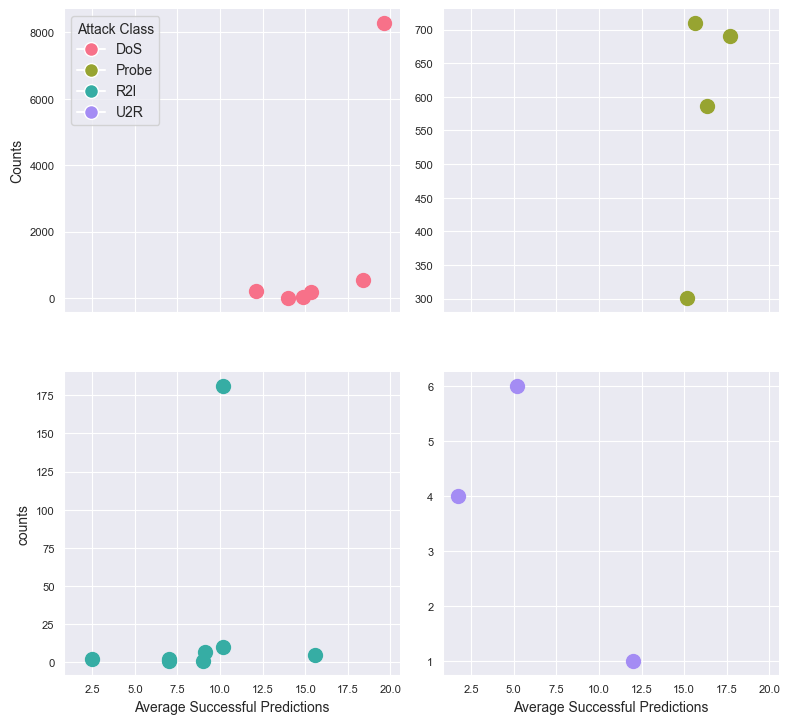

In [39]:
# Filter out observations with 'normal' attack_class and attack_type
filtered_train = train[(train['attack_class'] != 'normal') & (train['attack_type'] != 'normal')]
filtered_train['attack_class'] = filtered_train['attack_class'].cat.remove_unused_categories()

# Group by attack_class and attack_type and calculate the count of each group
grouped = filtered_train.groupby(['attack_class', 'attack_type'])['success_pred'].agg(['mean', 'size']).reset_index()
grouped.columns = ['attack_class', 'attack_type', 'success_pred', 'counts']

# Define colors for each unique attack_class
colors = sns.color_palette("husl", grouped['attack_class'].nunique())
color_dict = dict(zip(grouped['attack_class'].unique(), colors))

# Create a scatter plot for each attack_class using FacetGrid
g = sns.FacetGrid(grouped, col="attack_class", height=4, col_wrap=2, col_order=grouped['attack_class'].unique(), sharey=False)
g.map_dataframe(sns.scatterplot, x="success_pred", y="counts", s=100, color=".3")

for ax, title in zip(g.axes.flat, grouped['attack_class'].unique()):
    ax.scatter(grouped[grouped['attack_class'] == title]['success_pred'], 
               grouped[grouped['attack_class'] == title]['counts'], 
               color=color_dict[title], s=100)
    ax.set_title('')  # Remove titles

# Set y-axis label only for the first subplot
g.axes[0].set_ylabel('Counts')

# Set x-axis label only for the subplots in the bottom row
num_plots = len(g.axes)
col_wrap = 2  # As you're using col_wrap=2
bottom_row_axes_indices = [num_plots - col_wrap, num_plots - 1]

for idx in bottom_row_axes_indices:
    g.axes[idx].set_xlabel('Average Successful Predictions')

# Adjust spacing and main title
plt.subplots_adjust(top=0.9, hspace=0.2)  # Adjusted hspace to reduce the space between rows

# Add legend to the upper left of the top left panel
top_left_ax = g.axes[0]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
labels = grouped['attack_class'].unique()
top_left_ax.legend(handles=handles, labels=labels, loc='upper left', title='Attack Class')

plt.show()


# <span style="color:blue">Data Preprocessing

In [207]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# print(categorical_features)
# print(binary_features)
# print(continuous_features)
print(discrete_features)
# print(len(discrete_features))

# removed features: 'land', 'num_outbound_cmds', 'urgent', 'is_host_login', 'is_guest_login'
X_categorical_features = categorical_features[0:3]
X_binary_features = binary_features[1:3]
X_discrete_features = [discrete_features[i] for i in ([0] + list(range(2,22)))]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), X_categorical_features),
        ('bin', 'passthrough', X_binary_features),
        ('cont', StandardScaler(), continuous_features),
        ('int', StandardScaler(), X_discrete_features)
    ]
)

X = train.drop(['attack_class', 'attack_type', 'success_pred'], axis = 1)
X_prepro = preprocessor.fit_transform(X)

print("unprocessed features\n:", X.shape)
print(type(X))

print("\npreprocessed feaures:\n", X_prepro.shape)
print(type(X_prepro))


['wrong_fragment', 'urgent', 'su_attempted', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'success_pred']
unprocessed features
: (25192, 36)
<class 'pandas.core.frame.DataFrame'>

preprocessed feaures:
 (25192, 113)
<class 'numpy.ndarray'>


# <span style="color:blue">OneClassSVM On Full Preprocessed Data

In [232]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score

# model = OneClassSVM(nu=0.47, kernel='rbf', gamma='auto')
# model.fit(X_prepro)
# predictions = model.predict(X_prepro)

# normal_count = np.sum(predictions == 1)
# anomaly_count = np.sum(predictions == -1)

# print("Number of normal instances:", normal_count)
# print("Number of anomaly instances:", anomaly_count)
# Number of normal instances: 66768
# Number of anomaly instances: 59205

# silhouette_score(X_prepro, predictions)
# original silhouette_score on full data = 0.13840882193725837
# completion time = 84m 50.9s

Number of normal instances: 66768
Number of anomaly instances: 59205


# <span style="color:blue">Dimension Reduction

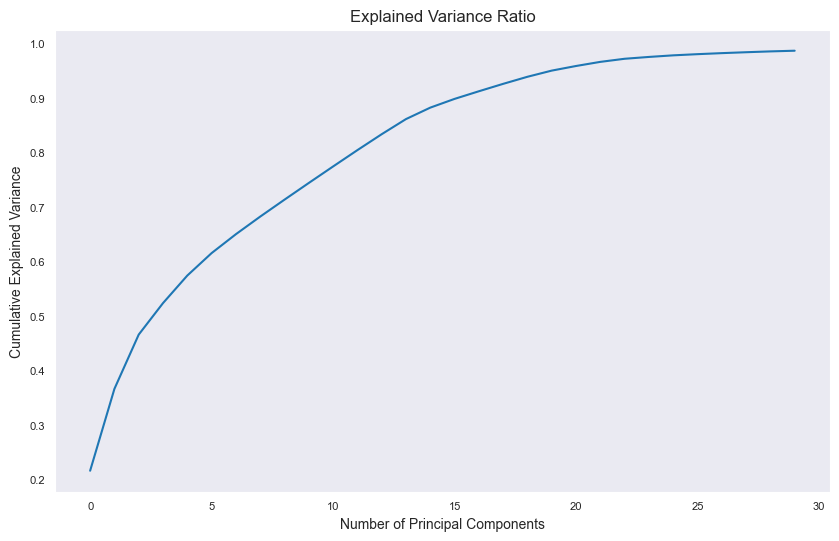

In [208]:
from sklearn.decomposition import PCA

pca = PCA(n_components = X_prepro.shape[1])
pca.fit(X_prepro)

exp_var_ratio = np.cumsum(pca.explained_variance_ratio_)[0:30]


# Set fontsizes
plt.rc('axes', titlesize = 8)
plt.rc('axes', labelsize = 10)
plt.rc('ytick', labelsize = 8)
plt.rc('xtick', labelsize = 8)

plt.figure(figsize=(10,6))
plt.plot(exp_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio', fontsize = 12)
plt.grid()
plt.show()

In [209]:
pca21 = PCA(n_components = 21)
X_pca21 = pca21.fit_transform(X_prepro)
X_pca21 = pd.DataFrame(X_pca21);

# <span style="color:blue">OneClassSVM with 21 PCA features

gamma:0.01, Adjusted Rand Index: 0.05
gamma:0.1, Adjusted Rand Index: 0.05
gamma:1.0, Adjusted Rand Index: 0.05
gamma:10.0, Adjusted Rand Index: 0.05


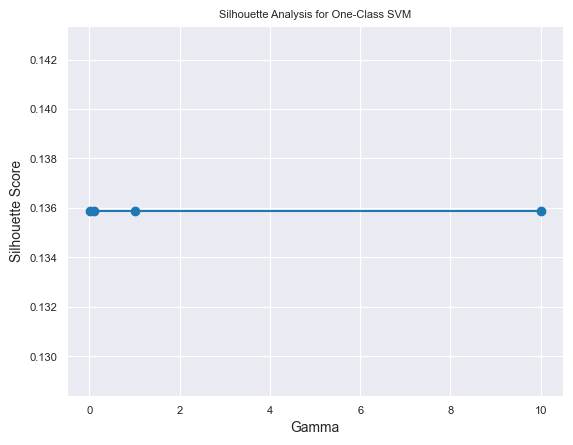

In [211]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score

binary_labels = np.where(train['attack_class']=='normal', 0, 1)

gamma_values = [.01, .1, 1.0, 10.0]
silhouette_scores = []
ari_scores = []

for gamma in gamma_values:
    model = OneClassSVM(nu=0.47, kernel='rbf', gamma='auto')
    model.fit(X_pca21)
    predictions = model.predict(X_pca21)
    silhouette_scores.append(silhouette_score(X_pca21, predictions))
    ari_scores.append(round(adjusted_rand_score(binary_labels, predictions), 2))

# normal_count = np.sum(predictions == 1)
# anomaly_count = np.sum(predictions == -1)
plt.plot(gamma_values, silhouette_scores, marker = 'o')
plt.xlabel('Gamma')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for One-Class SVM')
plt.show()

for i,gamma in enumerate(gamma_values):
    print(f"gamma:{gamma}, Adjusted Rand Index: {ari_scores[i]}") 

**Silhouette score** is a measure of how well clusters are separated. The score involves measuring cohesion, the similarity between a datum and other points in it's cluster, and separation, the average distance between a datum and points in the closest neighboring cluster. Scores range from -1 to 1, with high values indicating good separation. 

**Adjusted Rand Index** is a meaure of alignment between two clusterings, such as the two clusters identified by binary_labels in the train data (0 for normal, 1 for attack), and the normal/abnormal predictions from an unsupervised learning algorithm. Like the silhouette score, ARI ranges from -1 to 1. Positive 1 indicates perfect agreement, 0 indicates no different than random chance, and -1 indicates perfect disagreement.

# <span style="color:blue">Hierarchical agglomerative clustering

In [198]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_rand_score

linkage_method = ['ward', 'complete', 'average', 'single']
actual_labels = train['attack_class'].values
num_clusters = 5

for meth in linkage_method:
    Z = linkage(X_pca21, method = meth)
    clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
    ari_score = round(adjusted_rand_score(actual_labels, clusters), 2)
    print(f"{num_clusters}-Cluster, {meth} linkage, Adjusted Rand Index: {ari_score}")    

5-Cluster, ward linkage, Adjusted Rand Index: 0.67
5-Cluster, complete linkage, Adjusted Rand Index: -0.0
5-Cluster, average linkage, Adjusted Rand Index: -0.0
5-Cluster, single linkage, Adjusted Rand Index: 0.0


<AxesSubplot: title={'center': 'Dendrogram with Attack_Class Labels'}, xlabel='Data Points', ylabel='Distance'>

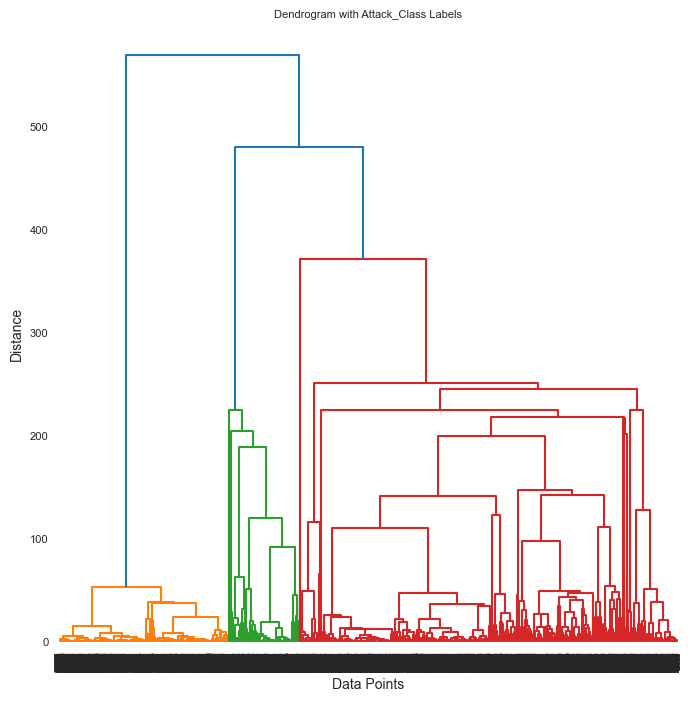

In [212]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(X_pca21, method='ward')

plt.figure(figsize =(8, 8))
plt.title('Dendrogram with Attack_Class Labels')
Dendrogram = dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('Distance')
ax = plt.gca()

### <span style="color:blue">5 Clusters - Adjusted Rand Index & Attack Class Distribution

In [213]:
from collections import Counter

actual_labels = train['attack_class'].values

# Cut the dendrogram to obtain 5 clusters
num_clusters = 5
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')

# Calculate Adjusted Rand Index to measure alignment
ari_score = round(adjusted_rand_score(actual_labels, clusters), 2)
print(f"{num_clusters}-Cluster, Adjusted Rand Index: {ari_score}")

# Get cluster assignments and attack class labels
cluster_assignments = clusters
attack_class_labels = train['attack_class']

# Get the dominate attack class for each cluster
prevalent_attack_by_cluster = {}
attack_counts_by_cluster = {}

for cluster_id in range(1, num_clusters + 1):
    cluster_indices = [i for i,c in enumerate(cluster_assignments) if c == cluster_id]
    cluster_attack_labels = [attack_class_labels[i] for i in cluster_indices]
    attack_counter = Counter(cluster_attack_labels)
    attack_counts_by_cluster[cluster_id] = attack_counter
    most_prevalent_label = max(attack_counter, key = attack_counter.get)
    prevalent_attack_by_cluster[cluster_id] = most_prevalent_label

print("Cluster-attack_class Mapping:", prevalent_attack_by_cluster)

# Get attack class counts for each cluster
for key,counter in attack_counts_by_cluster.items():
    print("\nAttack Class Distribution for cluster", key)
    for attack, count in counter.items():
        print('\t', attack, count)


5-Cluster, Adjusted Rand Index: 0.67
Cluster-attack_class Mapping: {1: 'DoS', 2: 'DoS', 3: 'normal', 4: 'Probe', 5: 'normal'}

Attack Class Distribution for cluster 1
	 DoS 6895
	 Probe 29
	 normal 14

Attack Class Distribution for cluster 2
	 DoS 1382
	 Probe 988
	 normal 516

Attack Class Distribution for cluster 3
	 normal 8

Attack Class Distribution for cluster 4
	 Probe 799
	 normal 62
	 R2l 1

Attack Class Distribution for cluster 5
	 normal 12849
	 R2l 208
	 DoS 957
	 Probe 473
	 U2R 11


### <span style="color:blue">2 Clusters - Adjusted Rand Index & Attack Class Distribution 

In [214]:

# Cut the dendrogram to obtain 2 clusters
num_clusters = 2
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')

# Calculate Adjusted Rand Index to measure alignment
ari_score = round(adjusted_rand_score(binary_labels, clusters), 2)
print(f"2-Cluster, Adjusted Rand Index: {ari_score}")

cluster_assignments = clusters
attack_class_labels = train['attack_class']
num_clusters = len(np.unique(clusters))

prevalent_attack_by_cluster = {}
attack_counts_by_cluster = {}

for cluster_id in range(1, num_clusters + 1):
    cluster_indices = [i for i,c in enumerate(cluster_assignments) if c == cluster_id]
    cluster_attack_labels = [attack_class_labels[i] for i in cluster_indices]
    attack_counter = Counter(cluster_attack_labels)
    attack_counts_by_cluster[cluster_id] = attack_counter
    most_prevalent_label = max(attack_counter, key = attack_counter.get)
    prevalent_attack_by_cluster[cluster_id] = most_prevalent_label

print("Cluster-attack_class Mapping:", prevalent_attack_by_cluster)

for key,counter in attack_counts_by_cluster.items():
    print("\nAttack Class Distribution for cluster", key)
    for attack, count in counter.items():
        print('\t', attack, count)

2-Cluster, Adjusted Rand Index: 0.38
Cluster-attack_class Mapping: {1: 'DoS', 2: 'normal'}

Attack Class Distribution for cluster 1
	 DoS 6895
	 Probe 29
	 normal 14

Attack Class Distribution for cluster 2
	 normal 13435
	 DoS 2339
	 R2l 209
	 Probe 2260
	 U2R 11


# <span style="color:blue">Summary

OneClassSVM proved to be slow and ineffective on the NSL_KDD dataset. Reducing the dataset size and dimension reduction with PCA reduced the processing time, but yeilded poor performance. The abundance of zero-inflated variables and the high rate of events (attakcs) may also not play to OneClassSVM's strenghts in anomaly and outlier detection. With an attack rate of 47%, we can hardly call these events outliers or anomalies.

Agglomerative hierarchical clustering yielded improved results and a 5-cluster separation that aligns reasonably well with attack class. In particluar, internet traffic records were reasonably separated into "normal" (cluster 5), "Probe" (cluster 4), and "DoS" (cluster 1).  

# <span style="color:blue">Referrences

#### NSL-KDD Data Source & Background
[Univeristy of New Brunswick, Canadian Institute for Cybersecurity, NSL-KDD dataset](https://www.unb.ca/cic/datasets/nsl.html)\
M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009.

#### KDDCup Data Source & Background
[KDD Cup 1999](https://kdd.org/kdd-cup/view/kdd-cup-1999/Intro)

### Additional Helfpull Information

S. Gerry, ["A Deeper Dive into the NSL-KDD Data Set"](https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657), Medium, Member-Only story.
